In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import string
import pickle
import random
import tarfile
import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
trainingmodule_dir = '/content/drive/MyDrive/capstone/'

europarlv7_de = os.path.join(trainingmodule_dir, 'europarl-v7.de-en.de')
europarlv7_en = os.path.join(trainingmodule_dir, 'europarl-v7.de-en.en')
commoncrawlv1_de = os.path.join(trainingmodule_dir, 'commoncrawl.de-en.de')
commoncrawlv1_en = os.path.join(trainingmodule_dir, 'commoncrawl.de-en.en')

In [4]:
def load_dataset(de_path, en_path):
    # Load parallel sentences from two text files and create a DataFrame.
    with open(de_path, 'r', encoding='utf-8') as de_file, open(en_path, 'r', encoding='utf-8') as en_file:
        de_sentences = de_file.readlines()
        en_sentences = en_file.readlines()

    # Check if lengths match
    if len(de_sentences) != len(en_sentences):
        print(f"Length mismatch: {de_path} ({len(de_sentences)}) and {en_path} ({len(en_sentences)})")
        # Truncate to the shorter length
        min_length = min(len(de_sentences), len(en_sentences))
        de_sentences = de_sentences[:min_length]
        en_sentences = en_sentences[:min_length]

    return pd.DataFrame({'German': de_sentences, 'English': en_sentences})

# Load datasets
europarl_f = load_dataset(europarlv7_de, europarlv7_en)
commoncrawl_f = load_dataset(commoncrawlv1_de, commoncrawlv1_en)

In [5]:
#Print the shape of each dataset
print("Shape of Europarl German dataset :",europarl_f.shape)

Shape of Europarl German dataset : (1920209, 2)


In [6]:
print("Shape of CommonCarl German dataset :",commoncrawl_f.shape)

Shape of CommonCarl German dataset : (2399123, 2)


In [7]:
# Merge the datasets
df = pd.concat([europarl_f, commoncrawl_f], ignore_index=True)

# Display the number of sentences
print(f"Total number of sentences in the dataset: {len(df)}")

Total number of sentences in the dataset: 4319332


In [8]:
# Display entire dataframe
pd.set_option('display.max_colwidth', None)  # Display full contents of each column without truncation
pd.set_option('display.max_rows', None)      # Display all rows

In [9]:
df.head(20)

,German,English
0,Wiederaufnahme der Sitzungsperiode\n,Resumption of the session\n
1,"Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.\n","I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.\n"
2,"Wie Sie feststellen konnten, ist der gefürchtete ""Millenium-Bug "" nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.\n","Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.\n"
3,Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tagen.\n,"You have requested a debate on this subject in the course of the next few days, during this part-session.\n"
4,"Heute möchte ich Sie bitten - das ist auch der Wunsch einiger Kolleginnen und Kollegen -, allen Opfern der Stürme, insbesondere in den verschiedenen Ländern der Europäischen Union, in einer Schweigeminute zu gedenken.\n","In the meantime, I should like to observe a minute' s silence, as a number of Members have requested, on behalf of all the victims concerned, particularly those of the terrible storms, in the various countries of the European Union.\n"
5,"Ich bitte Sie, sich zu einer Schweigeminute zu erheben.\n","Please rise, then, for this minute' s silence.\n"
6,(Das Parlament erhebt sich zu einer Schweigeminute.)\n,(The House rose and observed a minute' s silence)\n
7,"Frau Präsidentin, zur Geschäftsordnung.\n","Madam President, on a point of order.\n"
8,"Wie Sie sicher aus der Presse und dem Fernsehen wissen, gab es in Sri Lanka mehrere Bombenexplosionen mit zahlreichen Toten.\n",You will be aware from the press and television that there have been a number of bomb explosions and killings in Sri Lanka.\n
9,"Zu den Attentatsopfern, die es in jüngster Zeit in Sri Lanka zu beklagen gab, zählt auch Herr Kumar Ponnambalam, der dem Europäischen Parlament erst vor wenigen Monaten einen Besuch abgestattet hatte.\n","One of the people assassinated very recently in Sri Lanka was Mr Kumar Ponnambalam, who had visited the European Parliament just a few months ago.\n"


In [10]:
# Taking 5000 from each dataset to proceed with machine translation
europarl_f = europarl_f.sample(n=5000, random_state=42)
commoncrawl_f = commoncrawl_f.sample(n=5000, random_state=42)
# Merge the datasets
merged_df = pd.concat([europarl_f, commoncrawl_f], ignore_index=True)

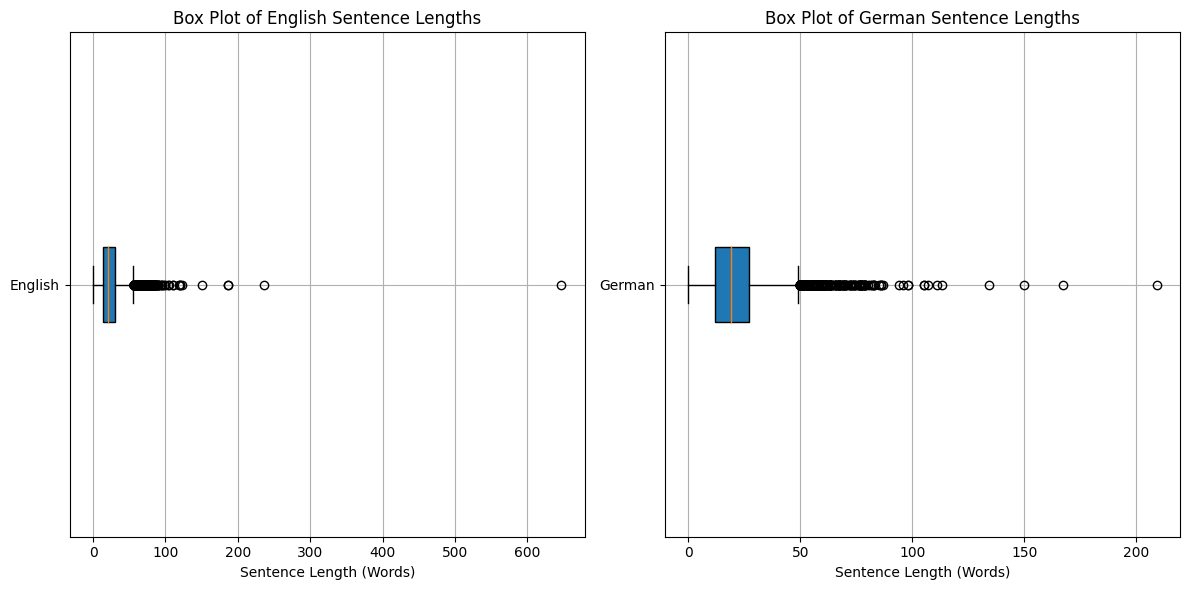

In [11]:
english_sentences = merged_df["English"].tolist()
german_sentences = merged_df["German"].tolist()

# Calculate sentence lengths
english_lengths = [len(sentence.split()) for sentence in english_sentences]
german_lengths = [len(sentence.split()) for sentence in german_sentences]

# Create a histogram plot with two subplots
plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Side-by-side box plots for English and German lengths
plt.subplot(1, 2, 1)
plt.boxplot(english_lengths, vert=False, patch_artist=True, labels=['English'])
plt.xlabel("Sentence Length (Words)")
plt.title("Box Plot of English Sentence Lengths")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.boxplot(german_lengths, vert=False, patch_artist=True, labels=['German'])
plt.xlabel("Sentence Length (Words)")
plt.title("Box Plot of German Sentence Lengths")
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
def cleanse_dataset(dataset):
    dataset = dataset[(dataset['German'].str.strip() != '') & (dataset['English'].str.strip() != '')]
    dataset.loc[:, 'German'] = dataset['German'].str.strip()
    dataset.loc[:, 'English'] = dataset['English'].str.strip()
    dataset = dataset.drop_duplicates()
    dataset.loc[:, 'German'] = dataset['German'].str.replace(r'[^a-zA-ZäöüßÄÖÜéèêàâçÇ\s]', '', regex=True)
    dataset.loc[:, 'English'] = dataset['English'].str.replace(r'[^a-zA-Z\s]', '', regex=True)
    dataset.loc[:, 'German'] = dataset['German'].str.lower()
    dataset.loc[:, 'English'] = dataset['English'].str.lower()
    return dataset

In [13]:
cleanse_df = cleanse_dataset(merged_df)
cleanse_df.shape

(9956, 2)

In [14]:
def rem_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [15]:
cleanse_df['German'] = cleanse_df['German'].apply(rem_punctuation)
cleanse_df['English'] = cleanse_df['English'].apply(rem_punctuation)

In [16]:
cleanse_df.head(5)

,German,English
0,falls es legal ist dann brauchen wir keine debatte zur führen,if it is legal we do not need a debate
1,weitere makrofinanzhilfe für georgien,further macrofinancial assistance for georgia
2,diese forderung verlief im sande zum einen weil das abkommen im juli ausläuft und zum anderen weil wir der ansicht waren dass ein so sensibles thema wie die dauer der vorratsspeicherung erforderlichenfalls gegenstand späterer verhandlungen sein könnte,the request came to nothing firstly because the agreement will come to an end in july and secondly because we have taken the view that a subject as sensitive as the period of data retention could if necessary be a topic for later negotiations
3,so funktioniert der rechtsstaat und lord bethell kann sicher sein dass das dänische rechtswesen entsprechend den prinzipien funktioniert die wir in dieser union hochhalten,that is how the judicial system works and lord bethell can be certain that the danish legal system functions in accordance with all the principles that we uphold in this union
4,wir sind daher durch die weigerung des rates die grundrechtecharta rechtsverbindlich zu machen in eine absurde situation geraten einerseits werden die grundrechte als zwingende konsequenz der anerkennung der würde des menschen betrachtet aber andererseits wird es den menschen verweigert sie tatsächlich als ihr recht geltend machen zu können,the councils refusal to make the charter of fundamental rights binding in law therefore puts us in an absurd situation in which on the one hand fundamental rights are regarded as an inevitable consequence of the recognition of human dignity whilst on the other hand people are denied the chance to exercise their rights


In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Flatten, Embedding, LSTM, TimeDistributed, Input, SimpleRNN, Bidirectional, Dense, RepeatVector, Concatenate, Attention, Dot, Activation
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
preprocessed_1_df = cleanse_df
train_df, test_df = train_test_split(preprocessed_1_df, test_size=0.2, random_state=42)
train_german = train_df['German']
train_english = train_df['English']
test_german = test_df['German']
test_english = test_df['English']
tokenizer_german = Tokenizer()
tokenizer_english = Tokenizer()
tokenizer_german.fit_on_texts(train_german)
tokenizer_english.fit_on_texts(train_english)

train_german_sequences = tokenizer_german.texts_to_sequences(train_german)
train_english_sequences = tokenizer_english.texts_to_sequences(train_english)
test_german_sequences = tokenizer_german.texts_to_sequences(test_german)
test_english_sequences = tokenizer_english.texts_to_sequences(test_english)

In [19]:
# Check language length
german_vocab = len(tokenizer_german.word_index) + 1
english_vocab = len(tokenizer_english.word_index) + 1

In [20]:
max_ger_len = int(len(max(train_german_sequences,key=len)))
max_eng_len = int(len(max(train_english_sequences,key=len)))
max_len = max(max_ger_len, max_eng_len)

train_german_padded = pad_sequences(train_german_sequences, maxlen=max_len, padding='post', truncating='post')
train_english_padded = pad_sequences(train_english_sequences, maxlen=max_len, padding='post', truncating='post')
test_german_padded = pad_sequences(test_german_sequences, maxlen=max_len, padding='post', truncating='post')
test_english_padded = pad_sequences(test_english_sequences, maxlen=max_len, padding='post', truncating='post')

train_english_padded_shifted = np.pad(train_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')
test_english_padded_shifted = np.pad(test_english_padded[:, 1:], ((0, 0), (0, 1)), 'constant')

In [21]:
tokenizer_path = '/content/drive/MyDrive/capstone/'
data_path = '/content/drive/MyDrive/capstone/'

with open(tokenizer_path + 'tokenizer_german.pkl', 'wb') as file:
    pickle.dump(tokenizer_german, file)
with open(tokenizer_path + 'tokenizer_english.pkl', 'wb') as file:
    pickle.dump(tokenizer_english, file)

# Saving the preprocessed data
np.save(data_path + 'train_german_padded.npy', train_german_padded)
np.save(data_path + 'train_english_padded_shifted.npy', train_english_padded_shifted)
np.save(data_path + 'test_german_padded.npy', test_german_padded)
np.save(data_path + 'test_english_padded_shifted.npy', test_english_padded_shifted)

print("Saved the tokenized data successfully.")

Saved the tokenized data successfully.


Simple RNN model

In [22]:
# Define the simple RNN model
basic_rnn_model = Sequential()
basic_rnn_model.add(SimpleRNN(256, input_shape=(max_len, 1), return_sequences=True))
basic_rnn_model.add(Dense(english_vocab, activation='softmax'))

# Compile the RNN model
basic_rnn_model.compile(optimizer= Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Printing the model summary
basic_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 645, 256)          66048     
                                                                 
 dense (Dense)               (None, 645, 19340)        4970380   
                                                                 
Total params: 5036428 (19.21 MB)
Trainable params: 5036428 (19.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
rnn_checkpoint_path = '/content/drive/MyDrive/capstone/rnncheckpoint.model.keras'
rnn_checkpoint = ModelCheckpoint(
    filepath=rnn_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [24]:
# Train the model with callbacks
history = basic_rnn_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=5,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[rnn_checkpoint, early_stopping]
)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 2.2371 - accuracy: 0.9331
Epoch 1: val_loss improved from inf to 0.27522, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
63/63 [==============================] - 363s 6s/step - loss: 2.2371 - accuracy: 0.9331 - val_loss: 0.2752 - val_accuracy: 0.9679
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 0.2897 - accuracy: 0.9652
Epoch 2: val_loss improved from 0.27522 to 0.26261, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
63/63 [==============================] - 365s 6s/step - loss: 0.2897 - accuracy: 0.9652 - val_loss: 0.2626 - val_accuracy: 0.9678
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 0.2832 - accuracy: 0.9652
Epoch 3: val_loss improved from 0.26261 to 0.25770, saving model to /content/drive/MyDrive/capstone/rnncheckpoint.model.keras
63/63 [==============================] - 365s 6s/step - loss: 0.2832 - accuracy: 0.9652

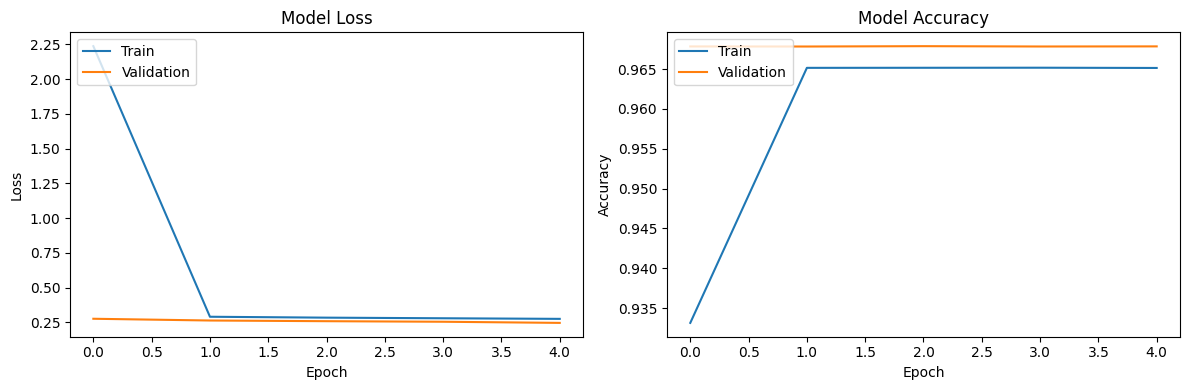

In [25]:
# Plot loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [26]:
basic_rnn_model.save('/content/drive/My Drive/capstone/rnn_model_checkpoint.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Load the weights into the model
rnn_checkpoint_path = '/content/drive/My Drive/capstone/rnn_model_checkpoint.h5'
best_rnn_model=load_model(rnn_checkpoint_path)

In [28]:
train_loss, train_accuracy = basic_rnn_model.evaluate(train_german_padded, np.expand_dims(train_english_padded_shifted, -1))
test_loss, test_accuracy = basic_rnn_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")
print(f"Training Loss: {train_loss}, Training Accuracy: {train_accuracy}")

63/63 [==============================] - 64s 1s/step - loss: 0.2455 - accuracy: 0.9679
Validation Loss: 0.24551349878311157, Validation Accuracy: 0.967864453792572
Training Loss: 0.269309401512146, Training Accuracy: 0.9651877284049988


In [29]:
accuracy = test_accuracy

In [30]:
rnn_results_df = pd.DataFrame({'Model': ['RNN'], 'Accuracy': [accuracy * 100]})
rnn_results_df

,Model,Accuracy
0,RNN,96.786445


In [44]:
random_indices = random.sample(range(len(test_german_padded)), 10)
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]
y_sample_pred = basic_rnn_model.predict(X_sample)
def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]
for i in range(len(random_indices)):
    print(f"Actual:   {sample_actual_decoded[i]}")
    print(f"Predicted: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 0s 151ms/step
Actual:   am completely convinced that the opinions widely held among the public and among animal rights organisations have contributed very significantly to our reaching this agreement
Predicted: the the the the the the the the the the the the the the the the

Actual:   assistance for ukraine
Predicted: the the the

Actual:   think that ultimately we are all agreed that the outcome of the european council is a success
Predicted: the the the the the the the the the the the the the the the the the the the

Actual:   please to my message because what i have to tell you tonight can bring healing to humanity and healing to our planet
Predicted: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

Actual:   believe that they deserve the same freedom as that which the european parliament is demanding for or
Predicted: the the the the the the the the the the the the the the

Simple LSTM model

In [32]:
# Define the model
basic_lstm_model = Sequential()
basic_lstm_model.add(LSTM(256, input_shape=(max_len, 1), return_sequences=True))
basic_lstm_model.add(Dense(english_vocab, activation='softmax'))

# Compile the model
basic_lstm_model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
basic_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 645, 256)          264192    
                                                                 
 dense_1 (Dense)             (None, 645, 19340)        4970380   
                                                                 
Total params: 5234572 (19.97 MB)
Trainable params: 5234572 (19.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
# Define the callbacks
lstm_checkpoint_path = '/content/drive/MyDrive/capstone/lstm_model_checkpoint.h5'
lstm_checkpoint = ModelCheckpoint(
    filepath=lstm_checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [34]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

history = basic_lstm_model.fit(
    train_german_padded,
    np.expand_dims(train_english_padded_shifted, -1),
    epochs=5,
    batch_size=128,
    validation_data=(test_german_padded, np.expand_dims(test_english_padded_shifted, -1)),
    callbacks=[lstm_checkpoint, early_stopping]
)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 2.4954 - accuracy: 0.9628
Epoch 1: val_loss improved from inf to 0.25556, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5
63/63 [==============================] - 456s 7s/step - loss: 2.4954 - accuracy: 0.9628 - val_loss: 0.2556 - val_accuracy: 0.9679
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.9653
Epoch 2: val_loss improved from 0.25556 to 0.24349, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5
63/63 [==============================] - 449s 7s/step - loss: 0.2718 - accuracy: 0.9653 - val_loss: 0.2435 - val_accuracy: 0.9679
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.9660
Epoch 3: val_loss improved from 0.24349 to 0.24104, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5
63/63 [==============================] - 443s 7s/step - loss: 0.2672 - accuracy: 0.9660 - val_loss: 0.2410 - val_accuracy: 0.9684
Epoch 4/5
63/63 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9662
Epoch 4: val_loss improved from 0.24104 to 0.24010, saving model to /content/drive/MyDrive/capstone/lstm_model_checkpoint.h5
63/63 [==============================] - 446s 7s/step - loss: 0.2657 - accuracy: 0.9662 - val_lo

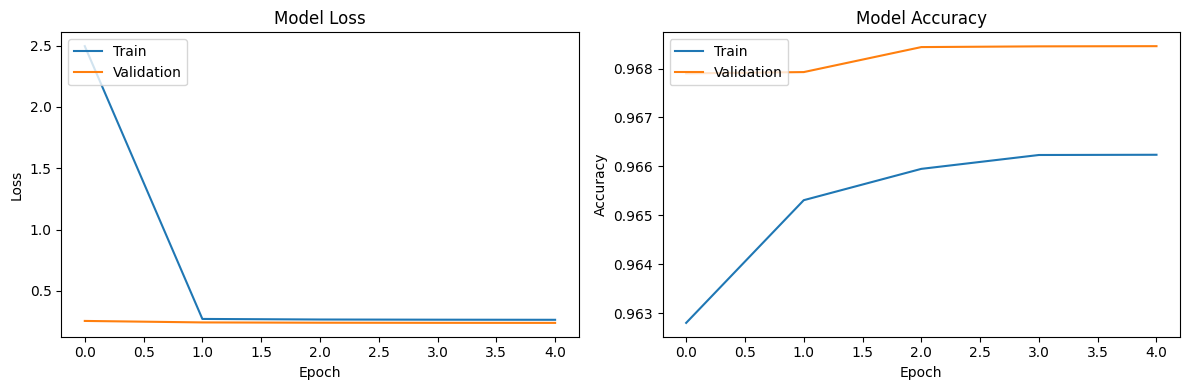

In [35]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [36]:
best_lstm_model = load_model(lstm_checkpoint_path)
best_lstm_model.load_weights(lstm_checkpoint_path)

In [37]:
test_loss, test_accuracy = basic_lstm_model.evaluate(test_german_padded, np.expand_dims(test_english_padded_shifted, -1))

63/63 [==============================] - 79s 1s/step - loss: 0.2397 - accuracy: 0.9685


In [38]:
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_accuracy}")

Validation Loss: 0.23965634405612946, Validation Accuracy: 0.9684567451477051


In [39]:
accuracy = test_accuracy

In [40]:
lstm_results_df = pd.DataFrame({'Model': ['LSTM'], 'Accuracy': [accuracy * 100]})
lstm_results_df

,Model,Accuracy
0,LSTM,96.845675


In [42]:
random_indices = random.sample(range(len(test_german_padded)), 10)
X_sample = test_german_padded[random_indices]
y_sample_actual = test_english_padded_shifted[random_indices]
y_sample_pred = basic_lstm_model.predict(X_sample)

def decode_sequence(tokenizer, sequence):
    reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
    decoded_sentence = ' '.join(reverse_word_map.get(token, '<unk>') for token in sequence if token != 0)
    return decoded_sentence
sample_actual_decoded = [decode_sequence(tokenizer_english, seq) for seq in y_sample_actual]
sample_pred_decoded = [decode_sequence(tokenizer_english, seq.argmax(axis=-1)) for seq in y_sample_pred]

for i in range(len(random_indices)):
    print(f"Actual English:   {sample_actual_decoded[i]}")
    print(f"Predicted English: {sample_pred_decoded[i]}\n")

1/1 [==============================] - 1s 578ms/step
Actual English:   legitimacy in other words a legal basis produced by including sport in the treaty and secondly an adequate budget for funding the most important aspects of europes approach to sport
Predicted English: the the the the the the the the the the the

Actual English:   exquisite greens and a stunning scenery provide the perfect environment for successful putting and
Predicted English: the

Actual English:   it should the impact of the plan it is presenting in agenda which will in the end make it more difficult to grant aid and will no doubt have the effect of eliminating structural funds measures for belgian objective and regions
Predicted English: the the the the

Actual English:   thirty four years of experience in blade
Predicted English: the the the the

Actual English:   the presence of thirdcountry workers must be evaluated with at least two considerations in mind
Predicted English: is the the the the the the the

A

In [43]:
# Combine RNN and LSTM results
combined_results_df = pd.concat([rnn_results_df, lstm_results_df], ignore_index=True)
combined_results_df

,Model,Accuracy
0,RNN,96.786445
1,LSTM,96.845675
